In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Load the dataset
df = pd.read_csv('STML.csv', nrows=10000, encoding='utf-8-sig')

# Extract dates before dropping the column
dates = df['Date']

# Define target variables (y) - BEFORE dropping
y_10cm = df['SDT10']
y_20cm = df['SDT20']
y_50cm = df['SDT50']

# Drop unwanted features (including 'Date' and target variables)
df = df.drop(['Date', 'SDT10', 'SDT20', 'SDT50'], axis=1)

# Define features(X)
X = df  # Now X doesn't contain 'Date' or target variables

In [ ]:
# Combine the target variables into a single DataFrame or array if needed
y = pd.DataFrame({'SDT10': y_10cm, 'SDT20': y_20cm, 'SDT50': y_50cm})

In [ ]:
df.head()

,Tmax,Tmin,STS,ET,WS,RAD,SS,H
0,13.7,3.8,25.4,1.4,0.5,259.0,8.2,86.0
1,12.0,4.0,16.0,1.0,1.6,130.0,0.1,91.0
2,10.5,8.5,10.5,1.0,2.3,10.0,0.0,94.0
3,14.5,8.6,18.8,1.4,0.8,247.0,7.2,82.0
4,14.5,3.4,19.6,0.5,0.6,178.0,3.5,92.0


In [ ]:
X.head()

,Tmax,Tmin,STS,ET,WS,RAD,SS,H
0,13.7,3.8,25.4,1.4,0.5,259.0,8.2,86.0
1,12.0,4.0,16.0,1.0,1.6,130.0,0.1,91.0
2,10.5,8.5,10.5,1.0,2.3,10.0,0.0,94.0
3,14.5,8.6,18.8,1.4,0.8,247.0,7.2,82.0
4,14.5,3.4,19.6,0.5,0.6,178.0,3.5,92.0


In [ ]:
y.head()

,SDT10,SDT20,SDT50
0,9.6,10.6,12.5
1,9.5,10.5,12.7
2,10.2,10.8,12.5
3,10.5,11.0,12.7
4,9.8,11.0,12.7


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tmax    3287 non-null   float64
 1   Tmin    3287 non-null   float64
 2   STS     3287 non-null   float64
 3   ET      3287 non-null   float64
 4   WS      3287 non-null   float64
 5   RAD     3287 non-null   float64
 6   SS      3287 non-null   float64
 7   H       3287 non-null   float64
dtypes: float64(8)
memory usage: 205.6 KB


**PREPROCESS**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# Assuming X and y are your features and target variables
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming 'X' is your feature DataFrame and 'y' is your target variable(s)
# Split the data into training (70%), validation (15%), and testing (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and testing data using the fitted scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for LSTM input (if needed)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Now you have:
# - X_train_reshaped, y_train: Training data
# - X_val_reshaped, y_val: Validation data
# - X_test_reshaped, y_test: Testing data

In [ ]:
# Install necessary libraries
!pip install pandas numpy scikit-learn tensorflow matplotlib seaborn

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate, Attention
import matplotlib.pyplot as plt

# **LSTM**

In [ ]:
from tensorflow.keras.optimizers import Adam

def create_model(input_shape):
    input_layer = Input(shape=input_shape)

    # Stacked LSTM layers with Dropout
    lstm_out = LSTM(128, return_sequences=True)(input_layer)
    lstm_out = Dropout(0.2)(lstm_out)
    lstm_out = LSTM(64, return_sequences=True)(lstm_out)
    lstm_out = Dropout(0.2)(lstm_out)
    lstm_out = LSTM(32, return_sequences=True)(lstm_out)
    lstm_out = Dropout(0.2)(lstm_out)

    # Attention mechanism
    attention = Attention()([lstm_out, lstm_out])

    # Dense layers with L2 regularization
    dense_out1 = Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(attention)
    dense_out1 = Dropout(0.2)(dense_out1)
    output1 = Dense(1, name='ST_10cm')(dense_out1)

    dense_out2 = Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(attention)
    dense_out2 = Dropout(0.2)(dense_out2)
    output2 = Dense(1, name='ST_20cm')(dense_out2)

    dense_out3 = Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(attention)
    dense_out3 = Dropout(0.2)(dense_out3)
    output3 = Dense(1, name='ST_50cm')(dense_out3)

    model = Model(inputs=input_layer, outputs=[output1, output2, output3])
    return model

# Create the model
model = create_model((X_train_reshaped.shape[1], X_train_reshaped.shape[2]))

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_reshaped, [y_train['SDT10'], y_train['SDT20'], y_train['SDT50']],
                    validation_data=(X_val_reshaped, [y_val['SDT10'], y_val['SDT20'], y_val['SDT50']]),
                    epochs=200, batch_size=32, callbacks=[early_stopping])


Epoch 1/200
72/72 [==============================] - 11s 39ms/step - loss: 1451.7743 - ST_10cm_loss: 487.9713 - ST_20cm_loss: 479.1855 - ST_50cm_loss: 484.5026 - val_loss: 1441.7202 - val_ST_10cm_loss: 486.1536 - val_ST_20cm_loss: 476.1856 - val_ST_50cm_loss: 479.2668
Epoch 2/200
72/72 [==============================] - 1s 19ms/step - loss: 1444.4115 - ST_10cm_loss: 485.5447 - ST_20cm_loss: 477.0971 - ST_50cm_loss: 481.6556 - val_loss: 1431.6698 - val_ST_10cm_loss: 482.7094 - val_ST_20cm_loss: 473.3314 - val_ST_50cm_loss: 475.5149
Epoch 3/200
72/72 [==============================] - 1s 19ms/step - loss: 1424.8115 - ST_10cm_loss: 478.5560 - ST_20cm_loss: 471.5981 - ST_50cm_loss: 474.5429 - val_loss: 1391.9877 - val_ST_10cm_loss: 468.2268 - val_ST_20cm_loss: 462.0355 - val_ST_50cm_loss: 461.6099
Epoch 4/200
72/72 [==============================] - 1s 17ms/step - loss: 1326.1821 - ST_10cm_loss: 443.0927 - ST_20cm_loss: 442.5193 - ST_50cm_loss: 440.4532 - val_loss: 1209.5858 - val_ST_10cm_

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error


# Evaluate the model on the training set
y_train_pred = model.predict(X_train_reshaped)
# Evaluate the model on the test set
y_test_pred = model.predict(X_test_reshaped)
# Evaluate the model on the validation set
y_val_pred = model.predict(X_val_reshaped)

# Calculate metrics for each output
outputs = ['SDT10', 'SDT20', 'SDT50']
for i, output in enumerate(outputs):
    print(f"Metrics for {output}:")

    # Training set metrics
    print("Training Set:")
    print("R2:", r2_score(y_train[output], y_train_pred[i].flatten()))
    print("RMSE:", np.sqrt(mean_squared_error(y_train[output], y_train_pred[i].flatten())))
    print("MSE:", mean_squared_error(y_train[output], y_train_pred[i].flatten()))

    # Test set metrics
    print("Test Set:")
    print("R2:", r2_score(y_test[output], y_test_pred[i].flatten()))
    print("RMSE:", np.sqrt(mean_squared_error(y_test[output], y_test_pred[i].flatten())))
    print("MSE:", mean_squared_error(y_test[output], y_test_pred[i].flatten()))
    print("----")

    # Val set metrics
    print("Validatio Set:")
    print("R2:", r2_score(y_val[output], y_val_pred[i].flatten()))
    print("RMSE:", np.sqrt(mean_squared_error(y_val[output], y_val_pred[i].flatten())))
    print("MSE:", mean_squared_error(y_val[output], y_val_pred[i].flatten()))
    print("----")



16/16 [==============================] - 0s 8ms/step
Metrics for SDT10:
Training Set:
R2: 0.9578227617719091
RMSE: 1.7461086750237316
MSE: 3.0488955049931312
Test Set:
R2: 0.9550235589941356
RMSE: 1.7402721252155395
MSE: 3.0285470698022103
----
Validatio Set:
R2: 0.9504644075565082
RMSE: 1.8656806982740832
MSE: 3.4807644679124707
----
Metrics for SDT20:
Training Set:
R2: 0.9404755385630272
RMSE: 1.8925536413968933
MSE: 3.5817592855646407
Test Set:
R2: 0.9360055864779495
RMSE: 1.9108631081256104
MSE: 3.6513978179954685
----
Validatio Set:
R2: 0.9328055738867
RMSE: 1.9771044126956125
MSE: 3.908941858700463
----
Metrics for SDT50:
Training Set:
R2: 0.8566552519433098
RMSE: 2.555672049364589
MSE: 6.531459623903396
Test Set:
R2: 0.8441851224793168
RMSE: 2.645553224617682
MSE: 6.998951864285015
----
Validatio Set:
R2: 0.8465899382297539
RMSE: 2.6035356268923078
MSE: 6.778397760497521
----


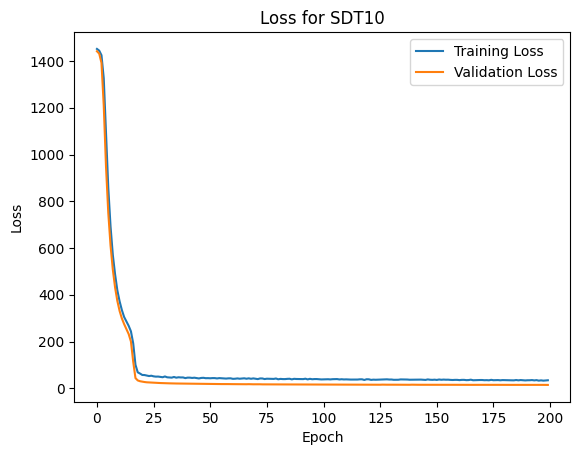

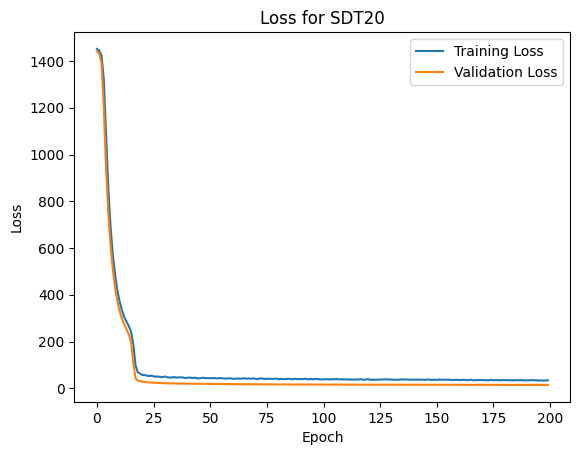

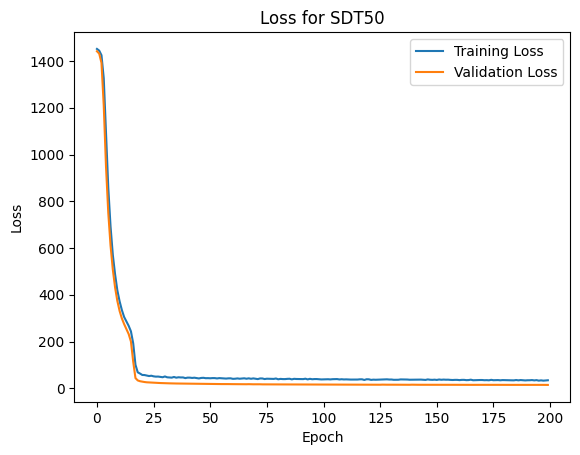

In [ ]:
# Visualize the training and validation loss for each output
for i, output in enumerate(outputs):
    plt.figure()  # Create a new figure for each output
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss for {output}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
# Print training and validation loss for each output
for i, output in enumerate(outputs):
    print(f"Training Loss for {output}:", history.history['loss'][i])
    print(f"Validation Loss for {output}:", history.history['val_loss'][i])
    print("----")

Training Loss for SDT10: 1451.7742919921875
Validation Loss for SDT10: 1441.72021484375
----
Training Loss for SDT20: 1444.4114990234375
Validation Loss for SDT20: 1431.6697998046875
----
Training Loss for SDT50: 1424.8115234375
Validation Loss for SDT50: 1391.9876708984375
----


In [ ]:

# Create DataFrames for predictions with dates and original y values
train_predictions_df = pd.DataFrame({
    'Date': dates.loc[X_train.index].values,
    'SDT10_pred': y_train_pred[0].flatten(),
    'SDT20_pred': y_train_pred[1].flatten(),
    'SDT50_pred': y_train_pred[2].flatten(),
    'SDT10_original': y_10cm.loc[X_train.index].values,
    'SDT20_original': y_20cm.loc[X_train.index].values,
    'SDT50_original': y_50cm.loc[X_train.index].values
})

test_predictions_df = pd.DataFrame({
    'Date': dates.loc[X_test.index].values,
    'SDT10_pred': y_test_pred[0].flatten(),
    'SDT20_pred': y_test_pred[1].flatten(),
    'SDT50_pred': y_test_pred[2].flatten(),
    'SDT10_original': y_10cm.loc[X_test.index].values,
    'SDT20_original': y_20cm.loc[X_test.index].values,
    'SDT50_original': y_50cm.loc[X_test.index].values
})
val_predictions_df = pd.DataFrame({
    'Date': dates.loc[X_val.index].values,
    'SDT10_pred': y_val_pred[0].flatten(),
    'SDT20_pred': y_val_pred[1].flatten(),
    'SDT50_pred': y_val_pred[2].flatten(),
    'SDT10_original': y_val['SDT10'].values,
    'SDT20_original': y_val['SDT20'].values,
    'SDT50_original': y_val['SDT50'].values
})


# Save predictions to CSV files in the "output" folder
train_predictions_df.to_csv('/content/drive/MyDrive/Colab Notebooks/output/train_predictionslstm.csv', index=False)
test_predictions_df.to_csv('/content/drive/MyDrive/Colab Notebooks/output/test_predictionslstm.csv', index=False)
val_predictions_df.to_csv('/content/drive/MyDrive/Colab Notebooks/output/val_predictionslstm.csv', index=False)

print("Train and test predictions with dates exported to the 'output' folder.")

Train and test predictions with dates exported to the 'output' folder.


# **CNN**

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

def create_cnn_model(input_shape):
    input_layer = Input(shape=input_shape)

    # Convolutional layers
    conv_out = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
    conv_out = Dropout(0.2)(conv_out)
    conv_out = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(conv_out)
    conv_out = Dropout(0.2)(conv_out)
    conv_out = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(conv_out)
    conv_out = Dropout(0.2)(conv_out)

    # Global average pooling
    pooled_out = GlobalAveragePooling1D()(conv_out)

    # Dense layers with L2 regularization
    dense_out1 = Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(pooled_out)
    dense_out1 = Dropout(0.2)(dense_out1)
    output1 = Dense(1, name='ST_10cm')(dense_out1)

    dense_out2 = Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(pooled_out)
    dense_out2 = Dropout(0.2)(dense_out2)
    output2 = Dense(1, name='ST_20cm')(dense_out2)

    dense_out3 = Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(pooled_out)
    dense_out3 = Dropout(0.2)(dense_out3)
    output3 = Dense(1, name='ST_50cm')(dense_out3)

    model = Model(inputs=input_layer, outputs=[output1, output2, output3])
    return model

# Create and compile the model
cnn_model = create_cnn_model((X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Train the model with early stopping
history_cnn = cnn_model.fit(X_train_reshaped, [y_train['SDT10'], y_train['SDT20'], y_train['SDT50']],
                            validation_data=(X_val_reshaped, [y_val['SDT10'], y_val['SDT20'], y_val['SDT50']]),
                            epochs=200, batch_size=32, callbacks=[early_stopping])


Epoch 1/200
72/72 [==============================] - 3s 9ms/step - loss: 1451.7798 - ST_10cm_loss: 487.4681 - ST_20cm_loss: 479.4473 - ST_50cm_loss: 484.7931 - val_loss: 1441.2448 - val_ST_10cm_loss: 485.4477 - val_ST_20cm_loss: 476.1040 - val_ST_50cm_loss: 479.6218
Epoch 2/200
72/72 [==============================] - 0s 4ms/step - loss: 1441.2083 - ST_10cm_loss: 483.0848 - ST_20cm_loss: 476.2608 - ST_50cm_loss: 481.7915 - val_loss: 1424.3644 - val_ST_10cm_loss: 478.2981 - val_ST_20cm_loss: 470.7560 - val_ST_50cm_loss: 475.2390
Epoch 3/200
72/72 [==============================] - 0s 4ms/step - loss: 1408.2350 - ST_10cm_loss: 469.3168 - ST_20cm_loss: 465.1519 - ST_50cm_loss: 473.6947 - val_loss: 1365.7513 - val_ST_10cm_loss: 454.1014 - val_ST_20cm_loss: 450.5255 - val_ST_50cm_loss: 461.0527
Epoch 4/200
72/72 [==============================] - 0s 4ms/step - loss: 1302.3364 - ST_10cm_loss: 427.9726 - ST_20cm_loss: 428.2874 - ST_50cm_loss: 446.0041 - val_loss: 1194.4708 - val_ST_10cm_loss:

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error


# Function to evaluate performance
def evaluate_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2

# Predictions
train_preds_cnn = cnn_model.predict(X_train_reshaped)
test_preds_cnn = cnn_model.predict(X_test_reshaped)
val_preds_cnn = cnn_model.predict(X_val_reshaped)

# Flatten predictions
train_preds_cnn = [pred.flatten() for pred in train_preds_cnn]
test_preds_cnn = [pred.flatten() for pred in test_preds_cnn]
val_preds_cnn = [pred.flatten() for pred in val_preds_cnn]

# Evaluate for each output
for i, name in enumerate(['SDT10', 'SDT20', 'SDT50']):
    train_mse, train_rmse, train_r2 = evaluate_performance(y_train[name], train_preds_cnn[i])
    test_mse, test_rmse, test_r2 = evaluate_performance(y_test[name], test_preds_cnn[i])
    val_mse, val_rmse, val_r2 = evaluate_performance(y_val[name], val_preds_cnn[i])

    print(f"--- {name} ---")
    print(f"Train MSE: {train_mse}, Train RMSE: {train_rmse}, Train R2: {train_r2}")
    print(f"Test MSE: {test_mse}, Test RMSE: {test_rmse}, Test R2: {test_r2}")
    print(f"Validation MSE: {val_mse}, Validation RMSE: {val_rmse}, Validation R2: {val_r2}")
    print("\n")

# Create DataFrames for predictions with dates and original y values
train_predictions_df = pd.DataFrame({
    'Date': dates.loc[X_train.index].values,
    'SDT10_pred': train_preds_cnn[0],
    'SDT20_pred': train_preds_cnn[1],
    'SDT50_pred': train_preds_cnn[2],
    'SDT10_original': y_train['SDT10'].values,
    'SDT20_original': y_train['SDT20'].values,
    'SDT50_original': y_train['SDT50'].values
})

val_predictions_df = pd.DataFrame({
    'Date': dates.loc[X_val.index].values,
    'SDT10_pred': val_preds_cnn[0],
    'SDT20_pred': val_preds_cnn[1],
    'SDT50_pred': val_preds_cnn[2],
    'SDT10_original': y_val['SDT10'].values,
    'SDT20_original': y_val['SDT20'].values,
    'SDT50_original': y_val['SDT50'].values
})

test_predictions_df = pd.DataFrame({
    'Date': dates.loc[X_test.index].values,
    'SDT10_pred': test_preds_cnn[0],
    'SDT20_pred': test_preds_cnn[1],
    'SDT50_pred': test_preds_cnn[2],
    'SDT10_original': y_test['SDT10'].values,
    'SDT20_original': y_test['SDT20'].values,
    'SDT50_original': y_test['SDT50'].values
})

# Save predictions to CSV files in the "output" folder
train_predictions_df.to_csv('/content/drive/MyDrive/Colab Notebooks/output/train_predictions_cnn.csv', index=False)
val_predictions_df.to_csv('/content/drive/MyDrive/Colab Notebooks/output/val_predictions_cnn.csv', index=False)
test_predictions_df.to_csv('/content/drive/MyDrive/Colab Notebooks/output/test_predictions_cnn.csv', index=False)

print("Train, validation, and test predictions with dates exported to the 'output' folder.")


16/16 [==============================] - 0s 2ms/step
--- SDT10 ---
Train MSE: 4.600002166663307, Train RMSE: 2.14476156405865, Train R2: 0.936365353645162
Test MSE: 4.350484800725974, Test RMSE: 2.085781580301728, Test R2: 0.9353916850301619
Validation MSE: 4.648464167110416, Validation RMSE: 2.1560297231509624, Validation R2: 0.9338465935880302


--- SDT20 ---
Train MSE: 4.566794145943145, Train RMSE: 2.1370058834601147, Train R2: 0.9241054631654476
Test MSE: 4.4361716237247535, Test RMSE: 2.1062221211744867, Test R2: 0.922251637456672
Validation MSE: 4.574698087023442, Validation RMSE: 2.1388543865872314, Validation R2: 0.9213612727661942


--- SDT50 ---
Train MSE: 7.3084138025860135, Train RMSE: 2.7034078128514043, Train R2: 0.8396035808915193
Test MSE: 7.550516508325839, Test RMSE: 2.747820319512511, Test R2: 0.8319058585091623
Validation MSE: 7.4079786838396045, Validation RMSE: 2.7217602179177365, Validation R2: 0.8323411361157587


Train, validation, and test predictions with da

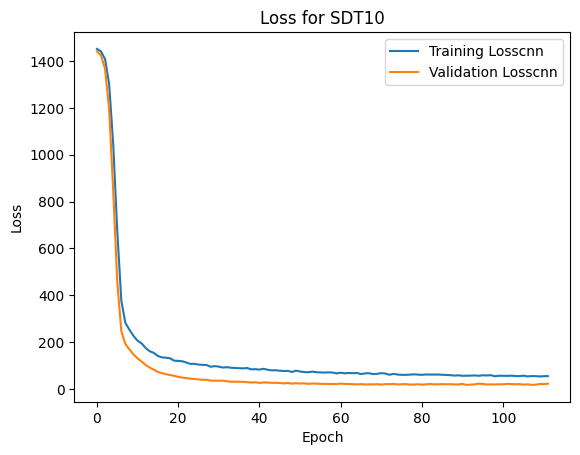

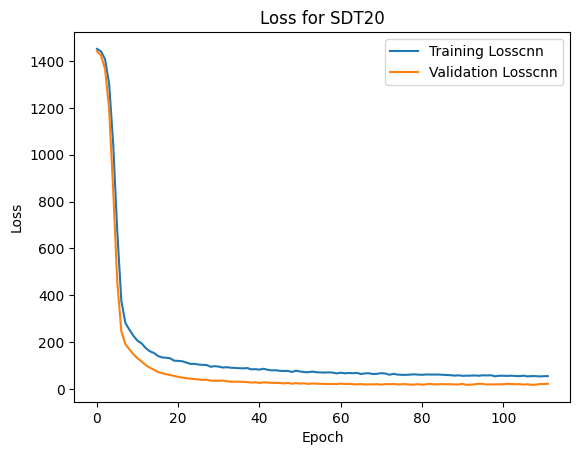

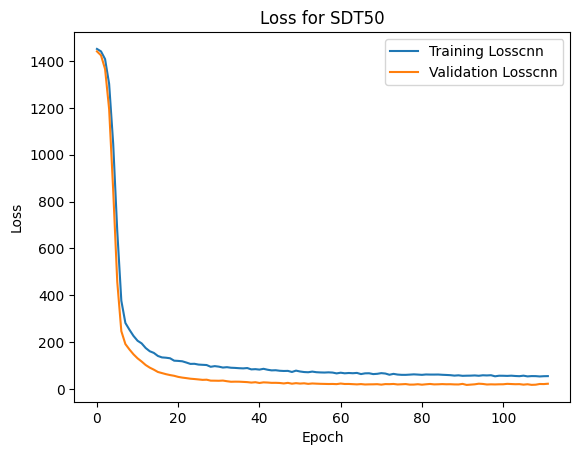

In [ ]:
# Visualize the training and validation loss for each output
for i, output in enumerate(outputs):
    plt.figure()  # Create a new figure for each output
    plt.plot(history_cnn.history['loss'], label='Training Losscnn')
    plt.plot(history_cnn.history['val_loss'], label='Validation Losscnn')
    plt.title(f'Loss for {output}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## **GatedGRU**

In [ ]:
from tensorflow.keras.layers import Input, GRU, Dropout, Dense, Attention
from tensorflow.keras.optimizers import Adam

def create_gru_model(input_shape):
    input_layer = Input(shape=input_shape)

    # Stacked GRU layers with Dropout
    gru_out = GRU(64, return_sequences=True)(input_layer)
    gru_out = Dropout(0.2)(gru_out)
    gru_out = GRU(32, return_sequences=True)(gru_out)
    gru_out = Dropout(0.2)(gru_out)
    gru_out = GRU(16, return_sequences=True)(gru_out)
    gru_out = Dropout(0.2)(gru_out)

    # Attention mechanism
    attention = Attention()([gru_out, gru_out])

    # Dense layers with L2 regularization
    dense_out1 = Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(attention)
    dense_out1 = Dropout(0.2)(dense_out1)
    output1 = Dense(1, name='ST_10cm')(dense_out1)

    dense_out2 = Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(attention)
    dense_out2 = Dropout(0.2)(dense_out2)
    output2 = Dense(1, name='ST_20cm')(dense_out2)

    dense_out3 = Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(attention)
    dense_out3 = Dropout(0.2)(dense_out3)
    output3 = Dense(1, name='ST_50cm')(dense_out3)

    model = Model(inputs=input_layer, outputs=[output1, output2, output3])
    return model

# Create and compile the model
gru_model = create_gru_model((X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
gru_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history_gru = gru_model.fit(X_train_reshaped, [y_train['SDT10'], y_train['SDT20'], y_train['SDT50']],
                            validation_data=(X_val_reshaped, [y_val['SDT10'], y_val['SDT20'], y_val['SDT50']]),
                            epochs=200, batch_size=32, callbacks=[early_stopping])



Epoch 1/200
72/72 [==============================] - 9s 29ms/step - loss: 1450.3209 - ST_10cm_loss: 487.5350 - ST_20cm_loss: 478.3734 - ST_50cm_loss: 484.3362 - val_loss: 1437.7603 - val_ST_10cm_loss: 485.1875 - val_ST_20cm_loss: 474.3984 - val_ST_50cm_loss: 478.0981
Epoch 2/200
72/72 [==============================] - 1s 10ms/step - loss: 1436.9447 - ST_10cm_loss: 483.9039 - ST_20cm_loss: 473.1313 - ST_50cm_loss: 479.8330 - val_loss: 1418.0494 - val_ST_10cm_loss: 479.7610 - val_ST_20cm_loss: 466.7827 - val_ST_50cm_loss: 471.4292
Epoch 3/200
72/72 [==============================] - 1s 12ms/step - loss: 1408.1262 - ST_10cm_loss: 475.9175 - ST_20cm_loss: 461.5749 - ST_50cm_loss: 470.5567 - val_loss: 1373.5760 - val_ST_10cm_loss: 467.4909 - val_ST_20cm_loss: 448.9754 - val_ST_50cm_loss: 457.0320
Epoch 4/200
72/72 [==============================] - 1s 12ms/step - loss: 1346.5642 - ST_10cm_loss: 458.1844 - ST_20cm_loss: 436.8076 - ST_50cm_loss: 451.4937 - val_loss: 1291.9943 - val_ST_10cm_l

In [ ]:
# Predictions
train_preds_gru = gru_model.predict(X_train_reshaped)
test_preds_gru = gru_model.predict(X_test_reshaped)
val_preds_gru = gru_model.predict(X_val_reshaped)

# Flatten predictions
train_preds_gru = [pred.flatten() for pred in train_preds_gru]
test_preds_gru = [pred.flatten() for pred in test_preds_gru]
val_preds_gru = [pred.flatten() for pred in val_preds_gru]

# Evaluate for each output
for i, name in enumerate(['SDT10', 'SDT20', 'SDT50']):
    train_mse, train_rmse, train_r2 = evaluate_performance(y_train[name], train_preds_gru[i])
    test_mse, test_rmse, test_r2 = evaluate_performance(y_test[name], test_preds_gru[i])
    val_mse, val_rmse, val_r2 = evaluate_performance(y_val[name], val_preds_gru[i])

    print(f"--- {name} ---")
    print(f"Train MSE: {train_mse}, Train RMSE: {train_rmse}, Train R2: {train_r2}")
    print(f"Test MSE: {test_mse}, Test RMSE: {test_rmse}, Test R2: {test_r2}")
    print(f"Validation MSE: {val_mse}, Validation RMSE: {val_rmse}, Validation R2: {val_r2}")
    print("\n")

# Create DataFrames for predictions with dates and original y values
train_predictions_df = pd.DataFrame({
    'Date': dates.loc[X_train.index].values,
    'SDT10_pred': train_preds_gru[0],
    'SDT20_pred': train_preds_gru[1],
    'SDT50_pred': train_preds_gru[2],
    'SDT10_original': y_train['SDT10'].values,
    'SDT20_original': y_train['SDT20'].values,
    'SDT50_original': y_train['SDT50'].values
})

val_predictions_df = pd.DataFrame({
    'Date': dates.loc[X_val.index].values,
    'SDT10_pred': val_preds_gru[0],
    'SDT20_pred': val_preds_gru[1],
    'SDT50_pred': val_preds_gru[2],
    'SDT10_original': y_val['SDT10'].values,
    'SDT20_original': y_val['SDT20'].values,
    'SDT50_original': y_val['SDT50'].values
})

test_predictions_df = pd.DataFrame({
    'Date': dates.loc[X_test.index].values,
    'SDT10_pred': test_preds_gru[0],
    'SDT20_pred': test_preds_gru[1],
    'SDT50_pred': test_preds_gru[2],
    'SDT10_original': y_test['SDT10'].values,
    'SDT20_original': y_test['SDT20'].values,
    'SDT50_original': y_test['SDT50'].values
})

# Save predictions to CSV files in the "output" folder
train_predictions_df.to_csv('/content/drive/MyDrive/Colab Notebooks/output/train_predictions_gru.csv', index=False)
val_predictions_df.to_csv('/content/drive/MyDrive/Colab Notebooks/output/val_predictions_gru.csv', index=False)
test_predictions_df.to_csv('/content/drive/MyDrive/Colab Notebooks/output/test_predictions_gru.csv', index=False)

print("Train, validation, and test predictions with dates exported to the 'output' folder.")


16/16 [==============================] - 0s 2ms/step
--- SDT10 ---
Train MSE: 3.411754647791112, Train RMSE: 1.8470935676871143, Train R2: 0.9528031090865455
Test MSE: 3.3617028229652686, Test RMSE: 1.833494702191765, Test R2: 0.9500759191745962
Validation MSE: 3.8182370742377816, Validation RMSE: 1.9540309808797254, Validation R2: 0.9456617541044062


--- SDT20 ---
Train MSE: 3.9708594318539028, Train RMSE: 1.9927015410878526, Train R2: 0.9340091697184597
Test MSE: 4.011710854313251, Test RMSE: 2.00292557383275, Test R2: 0.9296907386873672
Validation MSE: 4.2139225005776915, Validation RMSE: 2.0527840852310044, Validation R2: 0.9275629788450283


--- SDT50 ---
Train MSE: 6.735372635712488, Train RMSE: 2.5952596470704985, Train R2: 0.8521800104220607
Test MSE: 7.158817582606098, Test RMSE: 2.6755966778657236, Test R2: 0.8406260956703075
Validation MSE: 6.881454821169694, Validation RMSE: 2.6232527177475093, Validation R2: 0.8442575300999575


Train, validation, and test predictions wit

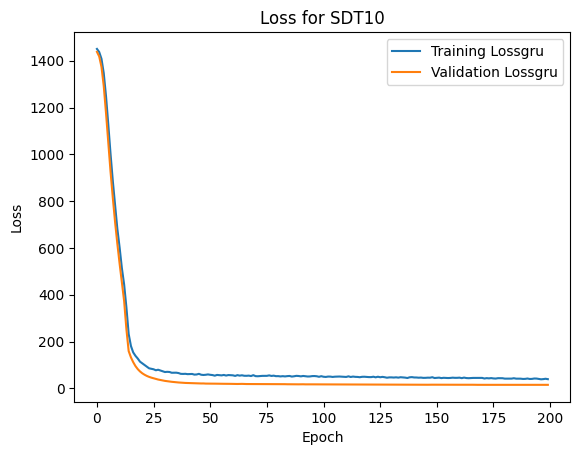

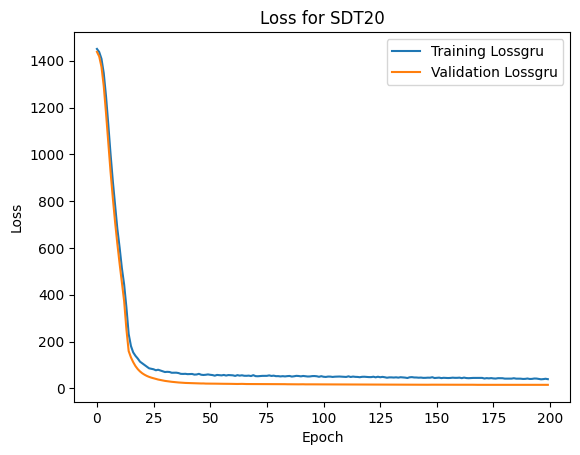

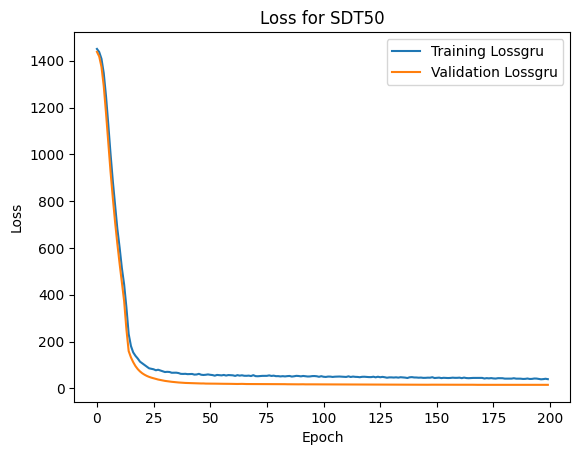

In [ ]:
# Visualize the training and validation loss for each output
for i, output in enumerate(outputs):
    plt.figure()  # Create a new figure for each output
    plt.plot(history_gru.history['loss'], label='Training Lossgru')
    plt.plot(history_gru.history['val_loss'], label='Validation Lossgru')
    plt.title(f'Loss for {output}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## **TRANSFORMER**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam

def create_transformer_model(input_shape):
    input_layer = Input(shape=input_shape)

    # Transformer block with adjusted dimensions
    attention_out = MultiHeadAttention(num_heads=4, key_dim=16)(input_layer, input_layer)  # Adjust key_dim for each head
    attention_out = Dropout(0.2)(attention_out)
    attention_out = LayerNormalization(epsilon=1e-6)(attention_out)

    dense_out = Dense(64, activation='relu')(attention_out)  # Adjusted to 64
    dense_out = Dropout(0.2)(dense_out)
    dense_out = LayerNormalization(epsilon=1e-6)(dense_out)

    dense_out = Dense(32, activation='relu')(dense_out)  # Added another Dense layer with 32 units
    dense_out = Dropout(0.2)(dense_out)
    dense_out = LayerNormalization(epsilon=1e-6)(dense_out)

    dense_out = Dense(16, activation='relu')(dense_out)  # Added another Dense layer with 16 units
    dense_out = Dropout(0.2)(dense_out)
    dense_out = LayerNormalization(epsilon=1e-6)(dense_out)

    # Dense layers with L2 regularization
    dense_out1 = Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(dense_out)
    dense_out1 = Dropout(0.2)(dense_out1)
    output1 = Dense(1, name='ST_10cm')(dense_out1)

    dense_out2 = Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(dense_out)
    dense_out2 = Dropout(0.2)(dense_out2)
    output2 = Dense(1, name='ST_20cm')(dense_out2)

    dense_out3 = Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(dense_out)
    dense_out3 = Dropout(0.2)(dense_out3)
    output3 = Dense(1, name='ST_50cm')(dense_out3)

    model = Model(inputs=input_layer, outputs=[output1, output2, output3])
    return model

# Create and compile the model
transformer_model = create_transformer_model((X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
transformer_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history_transformer = transformer_model.fit(X_train_reshaped, [y_train['SDT10'], y_train['SDT20'], y_train['SDT50']],
                                            validation_data=(X_val_reshaped, [y_val['SDT10'], y_val['SDT20'], y_val['SDT50']]),
                                            epochs=200, batch_size=32, callbacks=[early_stopping])


Epoch 1/200
72/72 [==============================] - 10s 33ms/step - loss: 1394.4570 - ST_10cm_loss: 470.0673 - ST_20cm_loss: 473.5952 - ST_50cm_loss: 450.7211 - val_loss: 1333.0583 - val_ST_10cm_loss: 448.9352 - val_ST_20cm_loss: 455.4189 - val_ST_50cm_loss: 428.6313
Epoch 2/200
72/72 [==============================] - 1s 12ms/step - loss: 1340.9849 - ST_10cm_loss: 451.2007 - ST_20cm_loss: 457.6295 - ST_50cm_loss: 432.0814 - val_loss: 1264.9833 - val_ST_10cm_loss: 425.6907 - val_ST_20cm_loss: 434.8253 - val_ST_50cm_loss: 404.3940
Epoch 3/200
72/72 [==============================] - 1s 12ms/step - loss: 1284.3695 - ST_10cm_loss: 431.8080 - ST_20cm_loss: 439.6745 - ST_50cm_loss: 412.8131 - val_loss: 1185.9728 - val_ST_10cm_loss: 400.1364 - val_ST_20cm_loss: 406.8865 - val_ST_50cm_loss: 378.8758
Epoch 4/200
72/72 [==============================] - 1s 12ms/step - loss: 1213.3091 - ST_10cm_loss: 407.6610 - ST_20cm_loss: 416.1400 - ST_50cm_loss: 389.4337 - val_loss: 1094.8900 - val_ST_10cm_

In [ ]:
# Predictions
train_preds_transformer = transformer_model.predict(X_train_reshaped)
test_preds_transformer = transformer_model.predict(X_test_reshaped)
val_preds_transformer = transformer_model.predict(X_val_reshaped)

# Flatten predictions
train_preds_transformer = [pred.flatten() for pred in train_preds_transformer]
test_preds_transformer = [pred.flatten() for pred in test_preds_transformer]
val_preds_transformer = [pred.flatten() for pred in val_preds_transformer]

# Evaluate for each output
for i, name in enumerate(['SDT10', 'SDT20', 'SDT50']):
    train_mse, train_rmse, train_r2 = evaluate_performance(y_train[name], train_preds_transformer[i])
    test_mse, test_rmse, test_r2 = evaluate_performance(y_test[name], test_preds_transformer[i])
    val_mse, val_rmse, val_r2 = evaluate_performance(y_val[name], val_preds_transformer[i])

    print(f"--- {name} ---")
    print(f"Train MSE: {train_mse}, Train RMSE: {train_rmse}, Train R2: {train_r2}")
    print(f"Test MSE: {test_mse}, Test RMSE: {test_rmse}, Test R2: {test_r2}")
    print(f"Validation MSE: {val_mse}, Validation RMSE: {val_rmse}, Validation R2: {val_r2}")
    print("\n")

# Create DataFrames for predictions with dates and original y values
train_predictions_df = pd.DataFrame({
    'Date': dates.loc[X_train.index].values,
    'SDT10_pred': train_preds_transformer[0],
    'SDT20_pred': train_preds_transformer[1],
    'SDT50_pred': train_preds_transformer[2],
    'SDT10_original': y_train['SDT10'].values,
    'SDT20_original': y_train['SDT20'].values,
    'SDT50_original': y_train['SDT50'].values
})

val_predictions_df = pd.DataFrame({
    'Date': dates.loc[X_val.index].values,
    'SDT10_pred': val_preds_transformer[0],
    'SDT20_pred': val_preds_transformer[1],
    'SDT50_pred': val_preds_transformer[2],
    'SDT10_original': y_val['SDT10'].values,
    'SDT20_original': y_val['SDT20'].values,
    'SDT50_original': y_val['SDT50'].values
})

test_predictions_df = pd.DataFrame({
    'Date': dates.loc[X_test.index].values,
    'SDT10_pred': test_preds_transformer[0],
    'SDT20_pred': test_preds_transformer[1],
    'SDT50_pred': test_preds_transformer[2],
    'SDT10_original': y_test['SDT10'].values,
    'SDT20_original': y_test['SDT20'].values,
    'SDT50_original': y_test['SDT50'].values
})

# Save predictions to CSV files in the "output" folder
train_predictions_df.to_csv('/content/drive/MyDrive/Colab Notebooks/output/train_predictions_transformer.csv', index=False)
val_predictions_df.to_csv('/content/drive/MyDrive/Colab Notebooks/output/val_predictions_transformer.csv', index=False)
test_predictions_df.to_csv('/content/drive/MyDrive/Colab Notebooks/output/test_predictions_transformer.csv', index=False)

print("Train, validation, and test predictions with dates exported to the 'output' folder.")


16/16 [==============================] - 0s 2ms/step
--- SDT10 ---
Train MSE: 5.152924046173708, Train RMSE: 2.2700052965078537, Train R2: 0.9287164467556206
Test MSE: 5.203929041051887, Test RMSE: 2.281212186766476, Test R2: 0.9227173287655521
Validation MSE: 5.302761304702612, Validation RMSE: 2.3027725256096425, Validation R2: 0.9245351343831654


--- SDT20 ---
Train MSE: 4.949409418374699, Train RMSE: 2.224726818819492, Train R2: 0.9177468649981063
Test MSE: 4.996270106983401, Test RMSE: 2.2352337924663273, Test R2: 0.9124353490823738
Validation MSE: 5.056405944961788, Validation RMSE: 2.248645357756929, Validation R2: 0.9130807497401507


--- SDT50 ---
Train MSE: 7.3444322715008745, Train RMSE: 2.710061304011567, Train R2: 0.8388130901514261
Test MSE: 8.076647939294814, Test RMSE: 2.841944394124349, Test R2: 0.8201928040310277
Validation MSE: 7.5983630049567, Validation RMSE: 2.756512834172317, Validation R2: 0.828032319859376


Train, validation, and test predictions with dates e

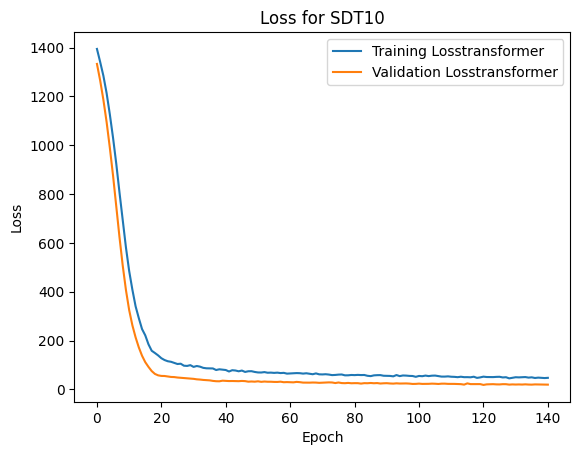

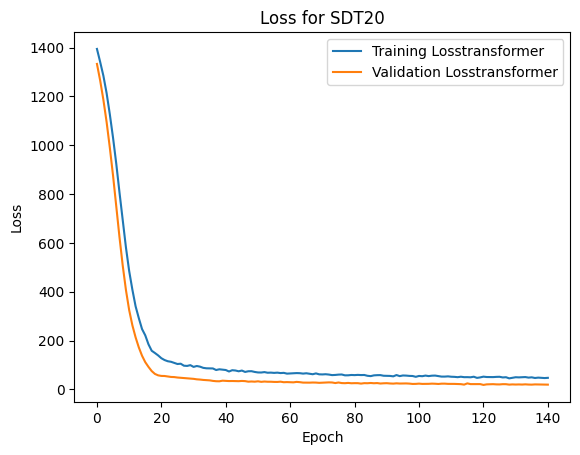

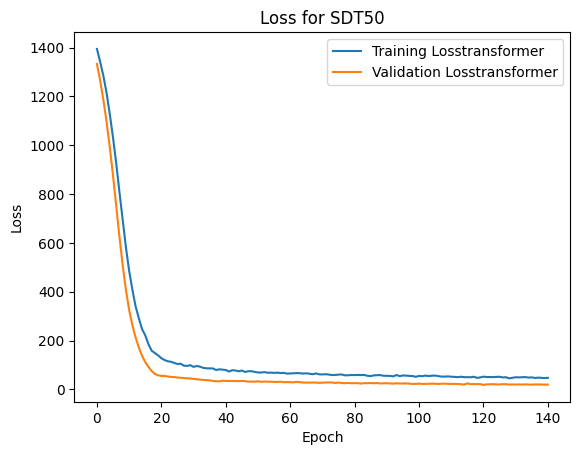

In [ ]:
# Visualize the training and validation loss for each output
for i, output in enumerate(outputs):
    plt.figure()  # Create a new figure for each output
    plt.plot(history_transformer.history['loss'], label='Training Losstransformer')
    plt.plot(history_transformer.history['val_loss'], label='Validation Losstransformer')
    plt.title(f'Loss for {output}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## **SensitivityAnalysis**

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

# Function to perturb inputs
def perturb_inputs(X, noise_level=0.1):
    noise = np.random.normal(loc=0.0, scale=noise_level, size=X.shape)
    return X + noise

# Function to evaluate performance
def evaluate_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2

# Function to run sensitivity analysis
def sensitivity_analysis(model, X, y, noise_levels):
    results = []

    for noise_level in noise_levels:
        X_perturbed = perturb_inputs(X, noise_level=noise_level)
        y_preds = model.predict(X_perturbed)

        for i, name in enumerate(['SDT10', 'SDT20', 'SDT50']):
            y_pred = y_preds[i].flatten()
            y_true = y[name].values

            mse, rmse, r2 = evaluate_performance(y_true, y_pred)

            results.append({
                'output': name,
                'noise_level': noise_level,
                'mse': mse,
                'rmse': rmse,
                'r2': r2
            })

    return pd.DataFrame(results)

# Define noise levels for sensitivity analysis
noise_levels = [0.01, 0.05, 0.1, 0.2, 0.3]

# Sensitivity analysis for LSTM model
lstm_results = sensitivity_analysis(model, X_test_reshaped, y_test, noise_levels)
lstm_results.to_csv('/content/drive/MyDrive/Colab Notebooks/output/lstm_sensitivity_analysis.csv', index=False)

# Sensitivity analysis for GRU model
gru_results = sensitivity_analysis(gru_model, X_test_reshaped, y_test, noise_levels)
gru_results.to_csv('/content/drive/MyDrive/Colab Notebooks/output/gru_sensitivity_analysis.csv', index=False)

# Sensitivity analysis for CNN model
cnn_results = sensitivity_analysis(cnn_model, X_test_reshaped, y_test, noise_levels)
cnn_results.to_csv('/content/drive/MyDrive/Colab Notebooks/output/cnn_sensitivity_analysis.csv', index=False)

# Sensitivity analysis for Transformer model
transformer_results = sensitivity_analysis(transformer_model, X_test_reshaped, y_test, noise_levels)
transformer_results.to_csv('/content/drive/MyDrive/Colab Notebooks/output/transformer_sensitivity_analysis.csv', index=False)

# Print results
print("LSTM Sensitivity Analysis")
print(lstm_results)

print("GRU Sensitivity Analysis")
print(gru_results)

print("CNN Sensitivity Analysis")
print(cnn_results)

print("Transformer Sensitivity Analysis")
print(transformer_results)


16/16 [==============================] - 0s 2ms/step
LSTM Sensitivity Analysis
   output  noise_level       mse      rmse        r2
0   SDT10         0.01  3.269448  1.808161  0.951446
1   SDT20         0.01  3.790548  1.946933  0.933567
2   SDT50         0.01  7.029223  2.651268  0.843511
3   SDT10         0.05  3.295006  1.815215  0.951066
4   SDT20         0.05  3.808023  1.951416  0.933261
5   SDT50         0.05  7.047421  2.654698  0.843106
6   SDT10         0.10  3.649650  1.910406  0.945800
7   SDT20         0.10  4.109461  2.027181  0.927978
8   SDT50         0.10  7.281472  2.698420  0.837895
9   SDT10         0.20  4.524507  2.127089  0.932807
10  SDT20         0.20  4.894695  2.212396  0.914216
11  SDT50         0.20  7.883714  2.807795  0.824488
12  SDT10         0.30  5.483908  2.341774  0.918559
13  SDT20         0.30  5.666771  2.380498  0.900684
14  SDT50         0.30  8.321436  2.884690  0.814743
GRU Sensitivity Analysis
   output  noise_level       mse      rmse      

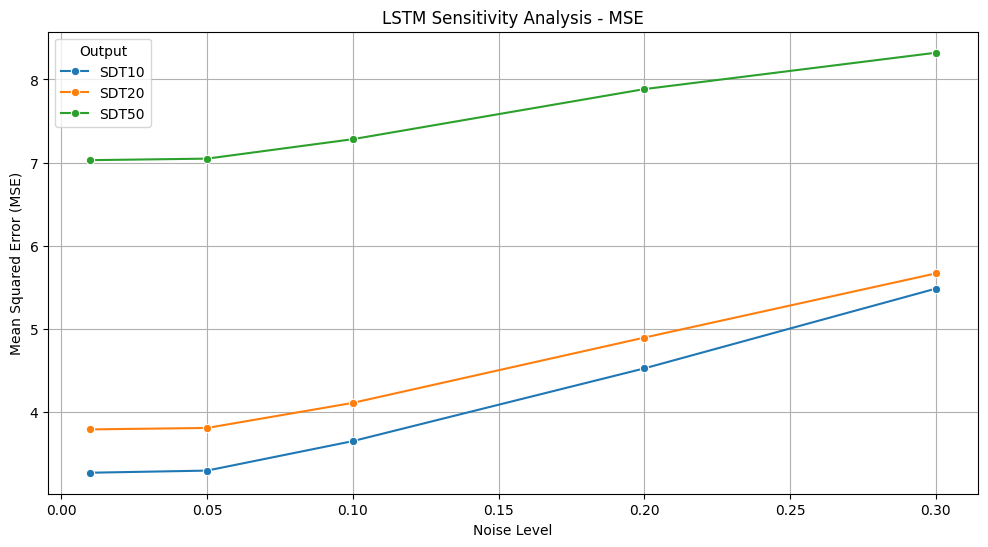

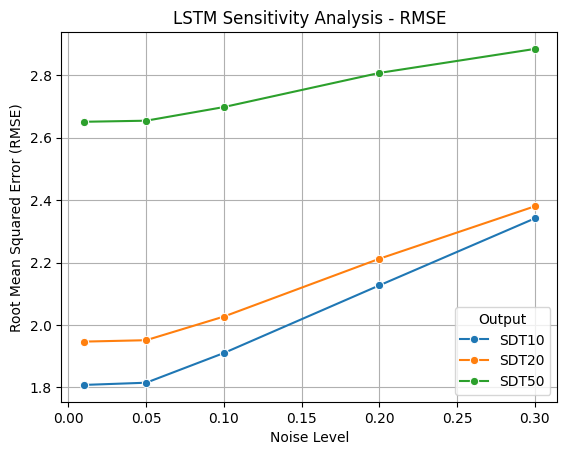

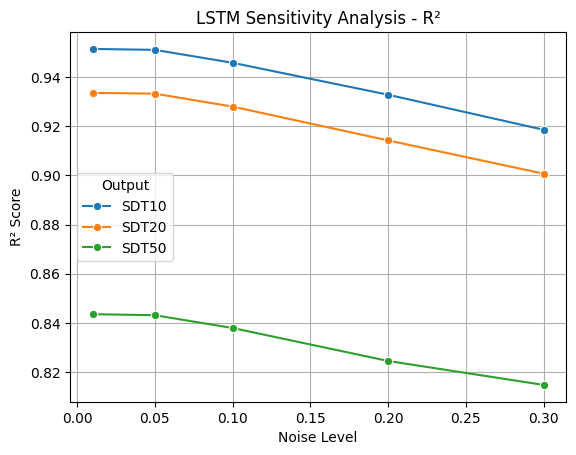

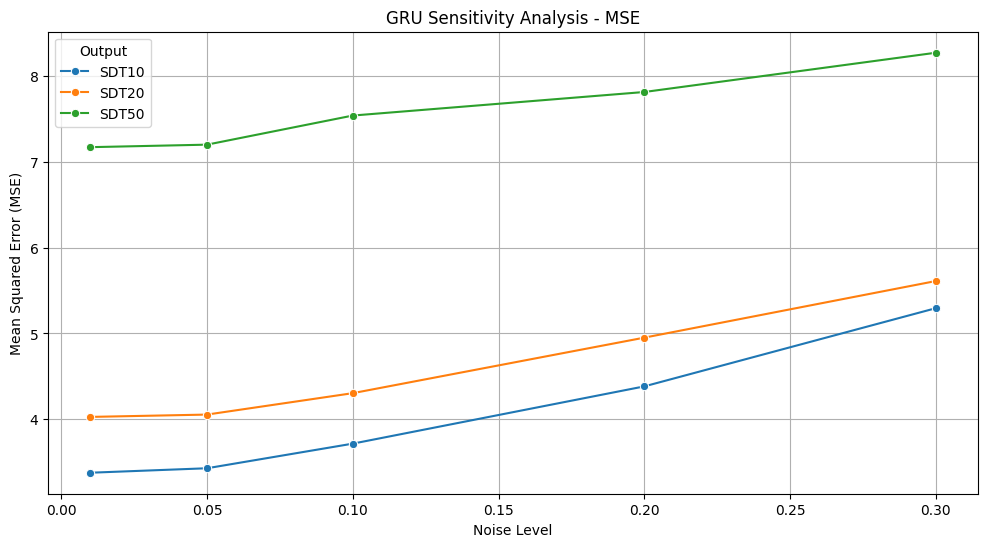

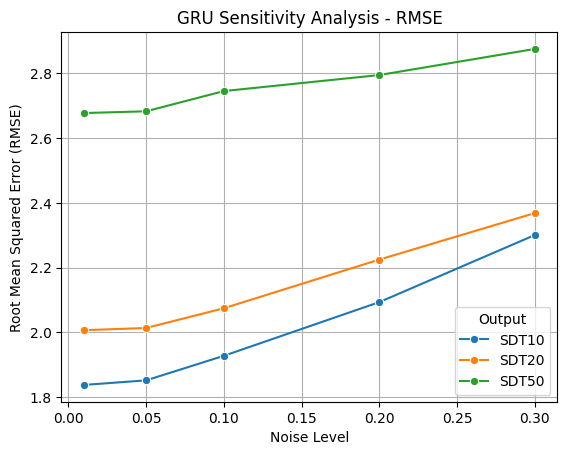

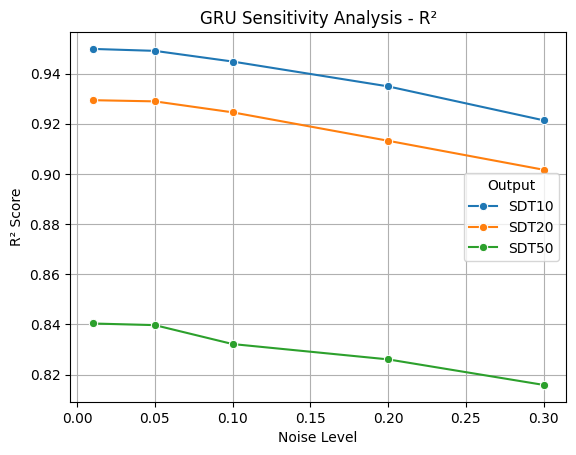

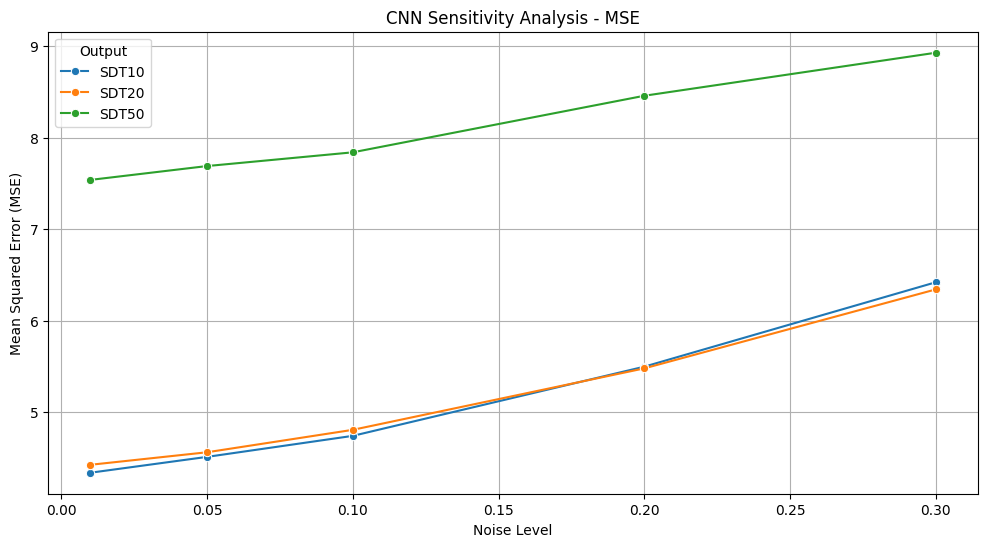

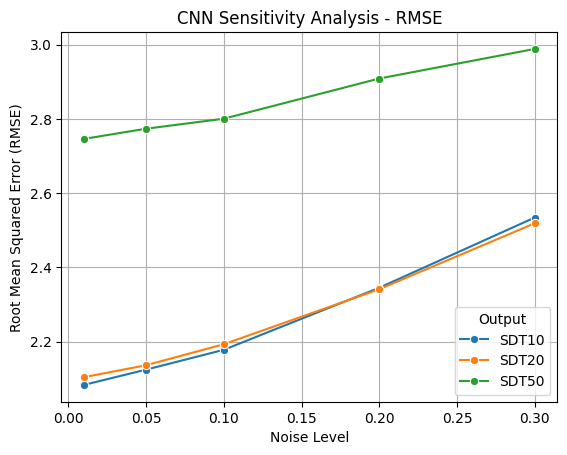

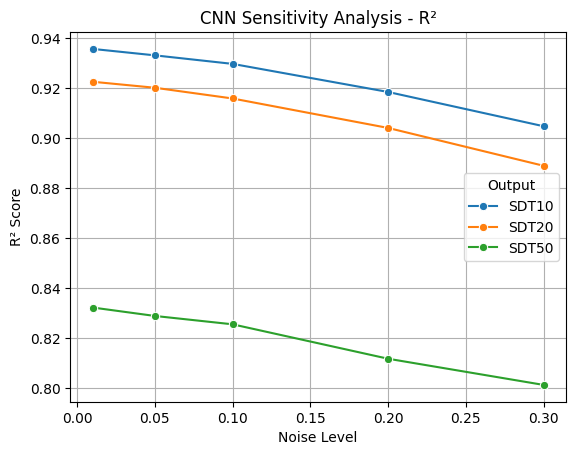

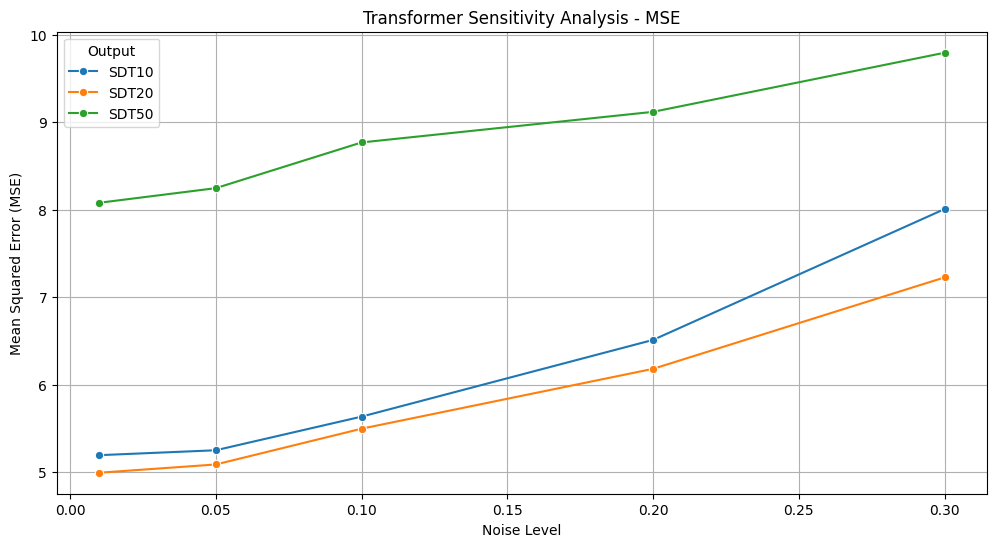

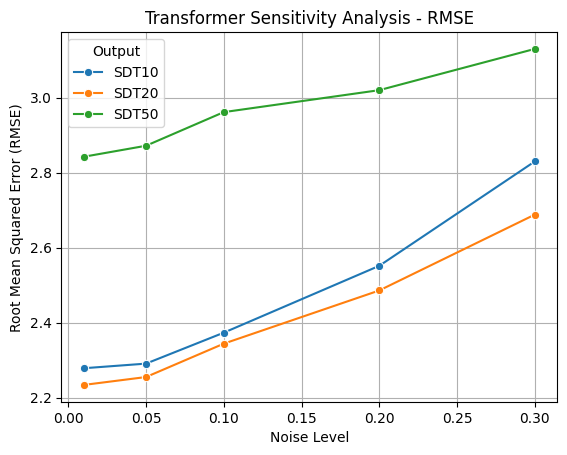

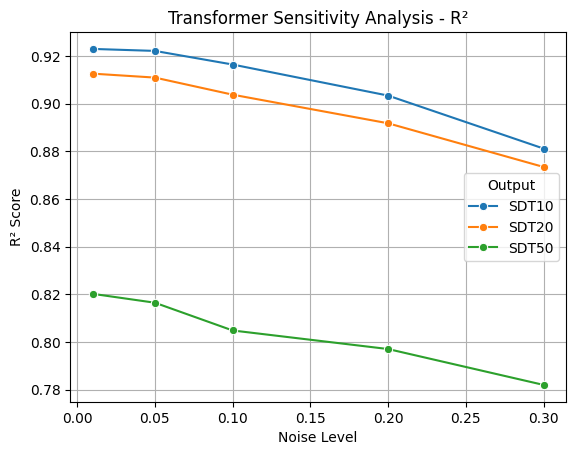

In [ ]:
# Function to plot sensitivity analysis results
def plot_sensitivity_analysis(results, model_name):
    plt.figure(figsize=(12, 6))

    sns.lineplot(data=results, x='noise_level', y='mse', hue='output', marker='o')
    plt.title(f'{model_name} Sensitivity Analysis - MSE')
    plt.xlabel('Noise Level')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.legend(title='Output')
    plt.grid(True)
    plt.show()

    sns.lineplot(data=results, x='noise_level', y='rmse', hue='output', marker='o')
    plt.title(f'{model_name} Sensitivity Analysis - RMSE')
    plt.xlabel('Noise Level')
    plt.ylabel('Root Mean Squared Error (RMSE)')
    plt.legend(title='Output')
    plt.grid(True)
    plt.show()

    sns.lineplot(data=results, x='noise_level', y='r2', hue='output', marker='o')
    plt.title(f'{model_name} Sensitivity Analysis - R²')
    plt.xlabel('Noise Level')
    plt.ylabel('R² Score')
    plt.legend(title='Output')
    plt.grid(True)
    plt.show()

# Plot sensitivity analysis results
plot_sensitivity_analysis(lstm_results, 'LSTM')
plot_sensitivity_analysis(gru_results, 'GRU')
plot_sensitivity_analysis(cnn_results, 'CNN')
plot_sensitivity_analysis(transformer_results, 'Transformer')
